# DESCRIÇÃO DO NEGÓCIO

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Submissions are evaluated on the Root Mean Square Percentage Error.

# 0.0 IMPORTS


In [1]:
from IPython.display       import Image
from IPython.core.display  import HTML
import warnings

import pandas as pd
import inflection # biblioteca para padronizar o nome das variaveis
import math
import numpy as np

from matplotlib            import pyplot as plt
import seaborn as sns

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


In [5]:
df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new



## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

Há 3 formas de substituir NAs
* Drop NA rows
* Using statistics and machine learning to infere data
* Understanding why the data is missing

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
#competition_distance              2642
# Imaginar que não há competidores próximos, ou seja, distância grande.
faraway = 100*df1.competition_distance.max()

df1['competition_distance'].fillna(faraway, inplace=True)

In [13]:
# A ideia aqui é aplicar o data atual (do dado lido) para dizer depois que não há tempo com concorrente.
# applicar df1.date para os campos de competition open since

#competition_open_since_month    323348
df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     323348
df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [14]:
# Para os dados de promo2_since_, fazer o mesmo. Aparentemente, não os dados faltantes são os que não há promo2,
# checar na mão!

print('Number of rows with promo2 == 0: {}'.format(df1[df1['promo2']== 0].shape[0]))
print('Number of rows with promo2 == 1 and missing since values: {}'.format((df1[df1['promo2']== 1 & (df1['promo2_since_week'].isna() | df1['promo2_since_year'].isna())].shape[0])))
      

Number of rows with promo2 == 0: 508031
Number of rows with promo2 == 1 and missing since values: 0


In [15]:
# Atribuir a data atual (da leitura) para dizer que não há tempo desde a última promo.
#promo2_since_week              508031

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


In [16]:
#promo_interval  

# criar month map dict
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# criar colunas 'month_map' com base em date
df1['month_map'] = df1['date'].dt.month.map(month_map)

# criar 'is_promo' comparando o map com promo_inverval
df1['promo_interval'].fillna('', inplace=True)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 1 if x['month_map'] in x['promo_interval'].split(',')
                            else 0 ,axis=1)



## 1.6. Change Data Types


In [30]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int64 )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int64 )

## 1.7. Descriptive Statistics

In [31]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [32]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [33]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,,Jul
4,0,a,a,,Jul


### 1.7.1. Numerical Atributes

Aqui parece ser mais razoável selecionar as colunas que façam sentido ter estatísticas.
Algumas variáveis aqui são categóricas mas o encoding já está feito como:
- store
- day_of_week
- promo2

In [35]:
# Central Tendency - mean, median 

m = num_attributes.describe()
#ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
#ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
#d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
#d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
#d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
#d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
#d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
#d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
#m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
#m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m
#ct1
m

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,2.511912e+04,6.786849e+00,2.010325e+03,5.005638e-01,2.361903e+01,2.012793e+03,1.659659e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,3.859093e+05,3.311087e+00,5.515593e+00,4.999999e-01,1.431006e+01,1.662658e+00,3.720502e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,4.000000e+00,2.008000e+03,0.000000e+00,1.200000e+01,2.012000e+03,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,7.000000e+00,2.012000e+03,1.000000e+00,2.200000e+01,2.013000e+03,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.910000e+03,1.000000e+01,2.014000e+03,1.000000e+00,3.700000e+01,2.014000e+03,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+06,1.200000e+01,2.015000e+03,1.000000e+00,5.200000e+01,2.015000e+03,1.000000e+00


<AxesSubplot:xlabel='competition_distance'>

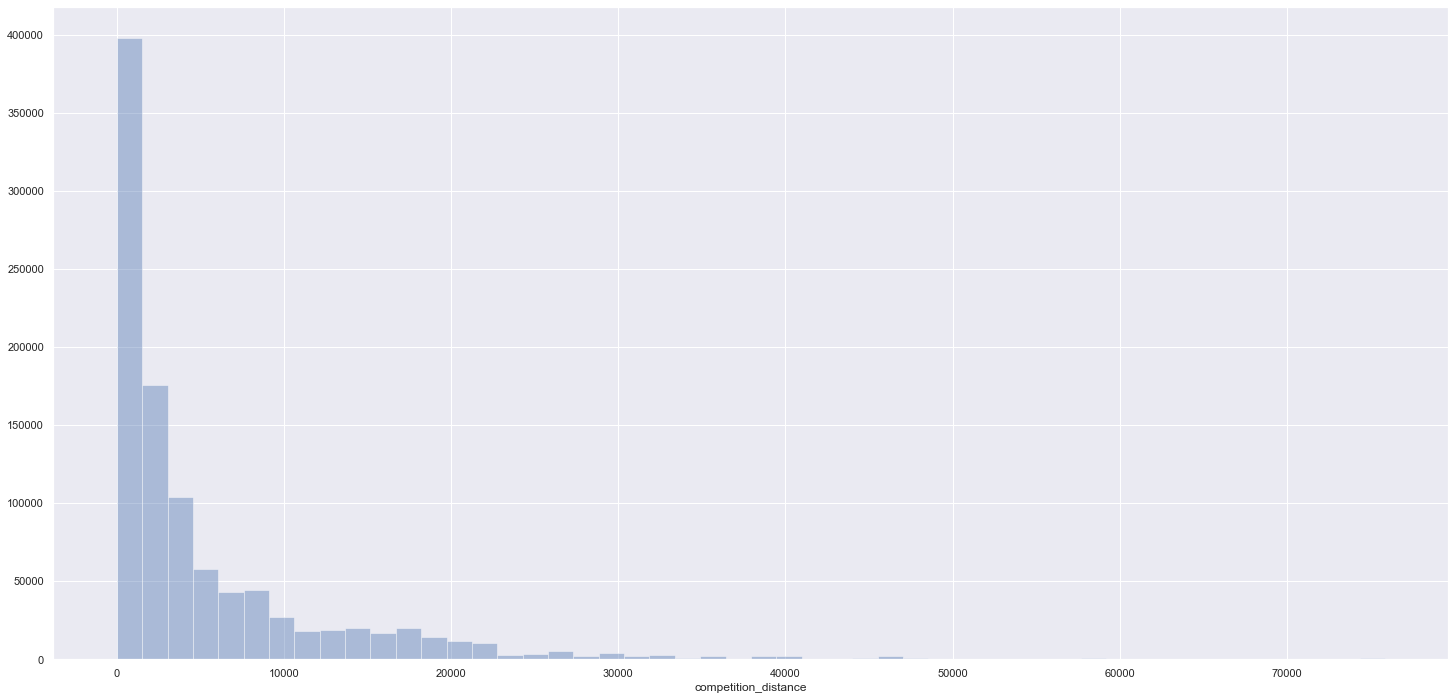

In [36]:
sns.distplot( df1['competition_distance'][df1['competition_distance']<faraway], kde=False )


In [23]:
df1['competition_distance'].median()

2330.0

### 1.7.2. Categorical Atributes

In [37]:
cat_attributes.apply( lambda x: x.unique().shape[0] )


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

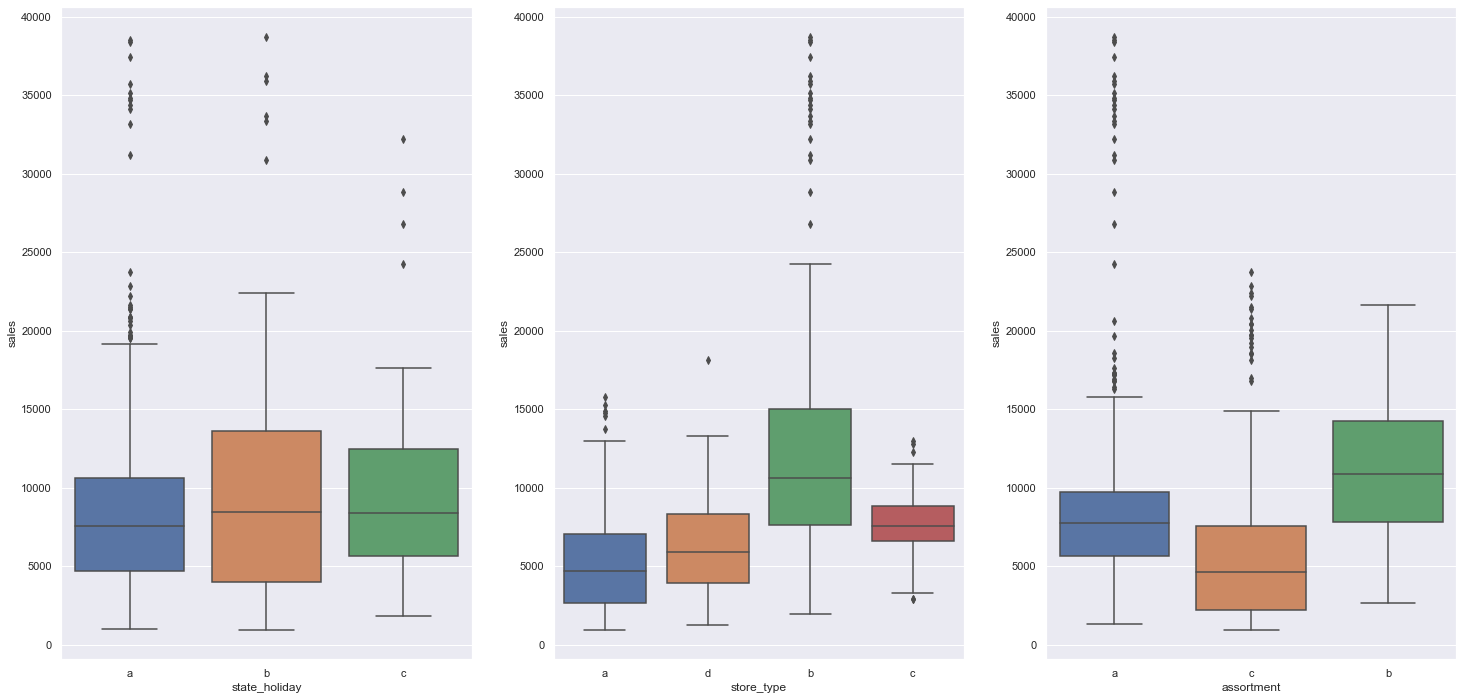

In [38]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. FEATURE ENGINEERING

In [39]:
df2 = df1.copy()

## 2.1. Hypothesys Mindmap

Fazer um mapa mental com as hipóteses a serem levantadas.

## 2.2. Criacao das Hipoteses


Registro da lista de hipóteses a serem avaliadas com brainstorming.

## 2.3. Lista Final de Hipóteses


Apenas escolher algumas hipóteses aparentemente mais relevantes.

## 2.4. Feature Engineering

Derivar algumas variáveis para facilitar a avaliação

In [40]:
# Derivando datas como variáveis categóricas
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [41]:
# competition since

# criando uma única feature para dizer a data de início da promoção
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

# calcula o timedelta do início da promoção para a data do registro
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int64 )

In [42]:
# promo since

# cria uma str com o formato da data
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

# transforma a str em data
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# calcula o timedelta da promoção em semanas
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int64 )

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS


In [43]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


In [44]:
# Exclui linhas quando as lojas estavam fechadas ou não houve vendas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Feature Selection

In [45]:
#Excluindo features que não fazem sentido para modelagem
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )